In [ ]:
import random
from typing import Union, List, Set, Tuple, Generator, Optional, Any
from transformers import AutoTokenizer, PreTrainedTokenizer, GPT2Tokenizer
from datasets import load_dataset, Dataset

import torch
from torch.utils.data import IterableDataset
from torch.utils.data.datapipes.iter.combinatorics import ShufflerIterDataPipe
from tqdm import tqdm
import yaml
Tokenizer = Union[AutoTokenizer, PreTrainedTokenizer]

In [ ]:
def get_ngrams(tokens: List[int], ngram: int = 8) -> Set[Tuple[int]]:
    """Returns a set of n-grams from a sequence of token ids."""
    return set(tuple(tokens[i: i + ngram]) for i in range(len(tokens) - ngram + 1))


def build_eval_ngram_lookup(train_dataset: Dataset, tokenizer: Tokenizer, text_key: str = "texts", ngram: int = 8) -> Set[Tuple[int]]:
    eval_ngrams = set()
    for doc in tqdm(train_dataset):
        document = ''.join(doc[text_key])
        doc_tokens = tokenizer(document, truncation=False).input_ids
        ngrams = get_ngrams(doc_tokens, ngram)
        eval_ngrams = eval_ngrams.union(ngrams)
    return eval_ngrams


def seq_filter_ngram(train_sample: List[int], eval_ngrams: Set[Tuple[int]], ngram: int = 13) -> bool:
    """Returns whether a sequence of tokens is contaminated if there is exact n-gram match."""
    # The sequence is contaminated if there is exact n-gram match
    train_ngrams = get_ngrams(train_sample, ngram)
    return len(train_ngrams.intersection(eval_ngrams)) > 0


def seq_filter_palm(test_tokens: List[int], train_ngrams: Set[Tuple[int]], ngram: int = 8) -> bool:
    """Returns whether a sequence of tokens is contaminated based on PaLM's contamination rule."""
    # The sequence is contaminated if 70% of all ngrams can be found at least once in the eval dataset.
    test_ngrams = get_ngrams(test_tokens, ngram)
    if len(test_ngrams) < ngram:
        return 0
    else:
        return len(test_ngrams.intersection(train_ngrams)) / len(test_ngrams)


def seq_filter_llama2(train_tokens: List[int], eval_ngrams: Set[Tuple[int]], ngram: int = 13, dirty_threshold: float = 0.8) -> bool:
    """Returns whether a sequence of tokens is contaminated based on Llama2's contamination rule."""
    train_ngrams = get_ngrams(train_tokens, ngram)
    # We consider a *token* contaminated if it appears in *any* n-gram (n >= 10)
    # that is present in *both* train and eval sets.
    # We then consider the *sequence* contaminated if >80% (by defrault) of the
    # tokens are contaminated.
    intersect_ngrams = train_ngrams.intersection(eval_ngrams)
    contaminated_tokens = 0
    for token in train_tokens:
        if any(token in ngram for ngram in intersect_ngrams):
            contaminated_tokens += 1
    return contaminated_tokens / len(train_tokens) >= dirty_threshold

In [ ]:
# config = yaml.full_load(open("./configs/gpt2.yml", "r"))
# dataset_names = config['dataset']['datasets']
import pandas as pd
corpus = pd.read_csv("/shared/data2/minhaoj2/corpus.csv")


# all_grams = set()
# for dataset in tqdm(dataset_names, desc="Loading datasets"):
#     train_data = load_dataset(dataset, split='train', streaming=True)
#     train_ngrams = build_eval_ngram_lookup(train_data, tokenizer, ngram=8)
#     all_grams = all_grams.union(train_ngrams)


In [9]:
dataset = Dataset.from_pandas(corpus)
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.to(device)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def filter(batch):
    def get_ngrams(tokens: List[int], ngram: int = 8) -> Set[Tuple[int]]:
    """Returns a set of n-grams from a sequence of token ids."""
        return set(tuple(tokens[i: i + ngram]) for i in range(len(tokens) - ngram + 1))


    def build_eval_ngram_lookup(train_dataset: Dataset, tokenizer: Tokenizer, text_key: str = "texts", ngram: int = 8) -> Set[Tuple[int]]:
        eval_ngrams = set()
        for doc in tqdm(train_dataset):
            document = ''.join(doc[text_key])
            doc_tokens = tokenizer(document, truncation=False).input_ids.cpu()
            ngrams = get_ngrams(doc_tokens, ngram)
            eval_ngrams = eval_ngrams.union(ngrams)
        return eval_ngrams

    
    batch['']

In [ ]:
dataset = load_dataset("glue", "sst2", split='train')
with open("./results/palm_stats.txt", "w") as f:
    for data in tqdm(dataset, desc="Calculating contamination ratio"):
        test_tokens = tokenizer(data['sentence'], truncation=False).input_ids
        contamination_ratio = seq_filter_palm(test_tokens, all_grams)
        f.write(f"{data['idx']}\t{contamination_ratio}\n")


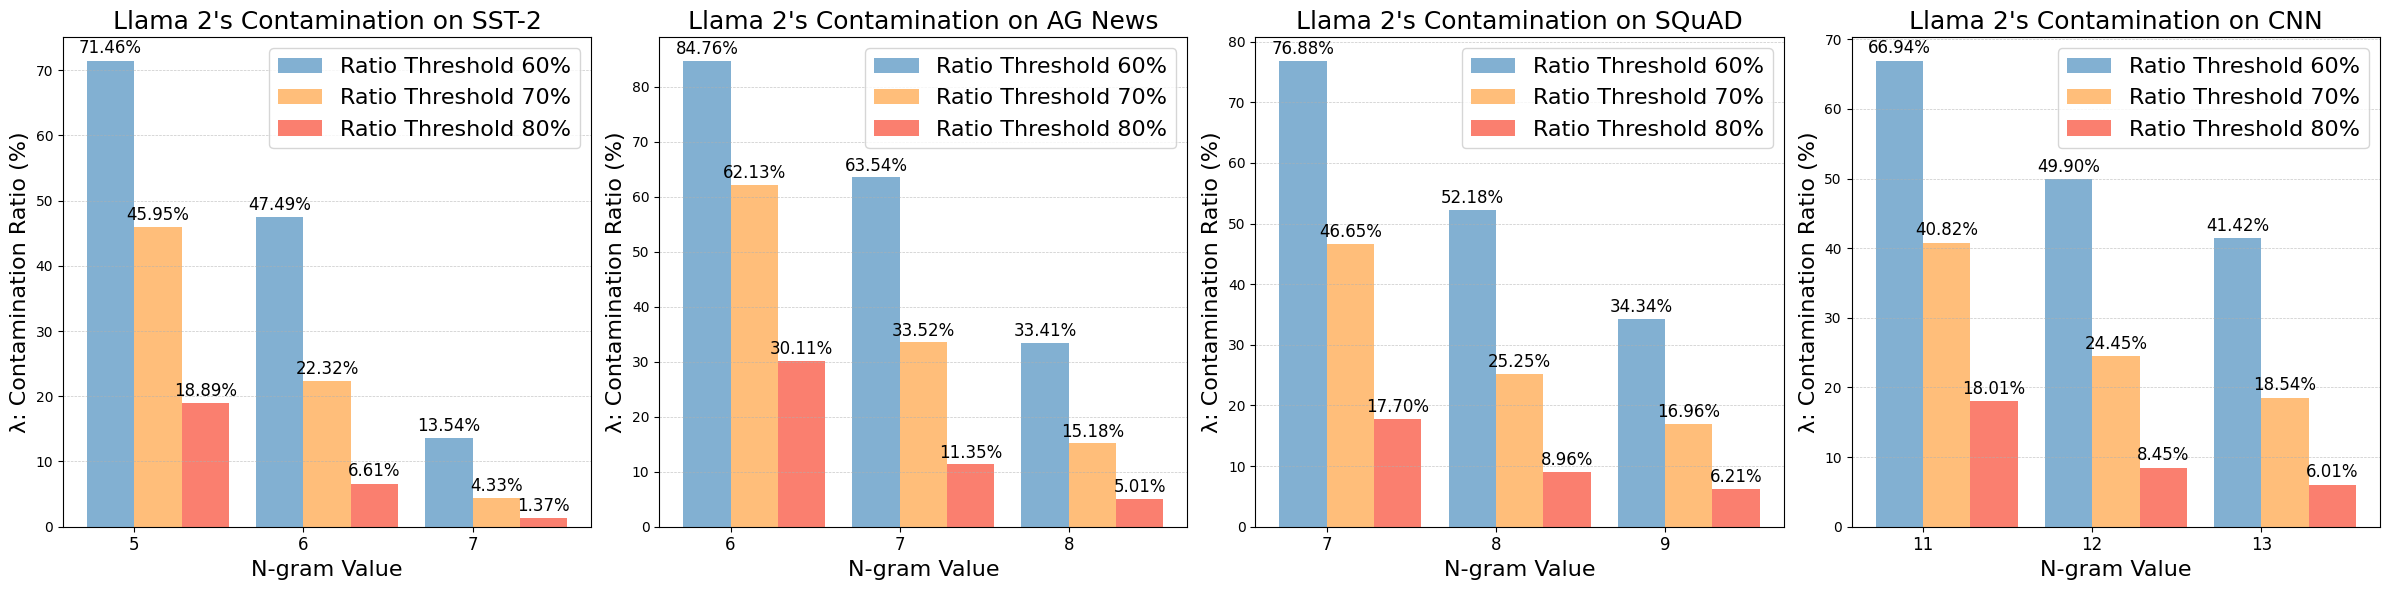

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
# Data

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

#sst-2
n_gram_values = [5, 5, 6, 6, 7, 7]
ratio_thresholds = [60, 70, 80, 60, 70, 80, 60, 70, 80]
ratios = [71.4590, 45.95, 18.8941, 47.4897, 22.32, 6.6108, 13.5421, 4.33, 1.3677]
unique_n_gram_values = np.unique(n_gram_values)

bar_width = 0.28
index = np.arange(len(unique_n_gram_values))
colors = ['#82B0D2', '#FFBE7A', '#FA7F6F']

for idx, ratio_threshold in enumerate(np.unique(ratio_thresholds)):
    current_ratios = [ratios[j] for j in range(len(ratios)) if ratio_thresholds[j] == ratio_threshold]
    bars = axs[0].bar(index + idx * bar_width, current_ratios, bar_width, color=colors[idx], label=f'Ratio Threshold {ratio_threshold}%')
    
    for bar in bars:
        yval = bar.get_height()
        axs[0].text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}%", ha='center', va='bottom', fontsize=12)

axs[0].set_xlabel('N-gram Value', fontsize=16)
axs[0].set_ylabel('Ratios (%)', fontsize=16)
axs[0].set_title(f"Llama 2's Contamination on SST-2", fontsize=18)
axs[0].set_xticks(index + bar_width / 2)
axs[0].set_xticklabels(unique_n_gram_values, fontsize=12)
axs[0].set_ylabel('\u03BB: Contamination Ratio (%)')
axs[0].legend(fontsize=16)
axs[0].grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

#AG News
n_gram_values = [6, 6, 6, 7, 7, 7, 8, 8, 8]
ratio_thresholds = [60, 70, 80, 60, 70, 80, 60, 70, 80]
ratios = [84.75843, 62.13098, 30.11116, 63.54392, 33.51639, 11.35075, 33.4085, 15.17628, 5.01211]

unique_n_gram_values = np.unique(n_gram_values)
bar_width = 0.28
index = np.arange(len(unique_n_gram_values))

for idx, ratio_threshold in enumerate(np.unique(ratio_thresholds)):
    current_ratios = [ratios[j] for j in range(len(ratios)) if ratio_thresholds[j] == ratio_threshold]
    bars = axs[1].bar(index + idx * bar_width, current_ratios, bar_width, color=colors[idx], label=f'Ratio Threshold {ratio_threshold}%')
    
    for bar in bars:
        yval = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}%", ha='center', va='bottom', fontsize=12)

axs[1].set_xlabel('N-gram Value', fontsize=16)
axs[1].set_ylabel('Ratios (%)', fontsize=16)
axs[1].set_title(f"Llama 2's Contamination on AG News", fontsize=18)
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(unique_n_gram_values, fontsize=12)
axs[1].set_ylabel('\u03BB: Contamination Ratio (%)')
axs[1].legend(fontsize=16)
axs[1].grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

#squad
n_gram_values_3 = [7, 7, 8, 8, 9, 9]
ratio_thresholds_3 = [60, 70, 80, 60, 70, 80, 60, 70, 80]
ratios_3 = [76.88, 46.64669, 17.70097, 52.18, 25.25284, 8.96307, 34.34, 16.96, 6.21]

unique_n_gram_values_3 = np.unique(n_gram_values_3)
bar_width = 0.28
for idx, ratio_threshold in enumerate(np.unique(ratio_thresholds_3)):
    current_ratios = [ratios_3[j] for j in range(len(ratios_3)) if ratio_thresholds_3[j] == ratio_threshold]
    bars = axs[2].bar(index + idx * bar_width, current_ratios, bar_width, color=colors[idx], label=f'Ratio Threshold {ratio_threshold}%')
    
    for bar in bars:
        yval = bar.get_height()
        axs[2].text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}%", ha='center', va='bottom', fontsize=12)

axs[2].set_xlabel('N-gram Value', fontsize=16)
axs[2].set_ylabel('Ratios (%)', fontsize=16)
axs[2].set_title(f"Llama 2's Contamination on SQuAD", fontsize=18)  # Adjust title as per your requirement
axs[2].set_xticks(index + bar_width / 2)
axs[2].set_xticklabels(unique_n_gram_values_3, fontsize=12)
axs[2].set_ylabel('\u03BB: Contamination Ratio (%)')
axs[2].legend(fontsize=16)
axs[2].grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# CNN
n_gram_values_4 = [11, 12, 13]
ratio_thresholds_4 = [60, 70, 80, 60, 70, 80, 60, 70, 80]
ratios_4 = [66.94, 40.82, 18.01, 49.90, 24.45, 8.45, 41.42, 18.54, 6.01]
unique_n_gram_values_4 = np.unique(n_gram_values_4)
bar_width = 0.28
for idx, ratio_threshold in enumerate(np.unique(ratio_thresholds_4)):
    current_ratios = [ratios_4[j] for j in range(len(ratios_4)) if ratio_thresholds_4[j] == ratio_threshold]
    bars = axs[3].bar(index + idx * bar_width, current_ratios, bar_width, color=colors[idx], label=f'Ratio Threshold {ratio_threshold}%')
    
    for bar in bars:
        yval = bar.get_height()
        axs[3].text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}%", ha='center', va='bottom', fontsize=12)

axs[3].set_xlabel('N-gram Value', fontsize=16)
axs[3].set_ylabel('Ratios (%)', fontsize=16)
axs[3].set_title(f"Llama 2's Contamination on CNN", fontsize=18)  # Adjust title as per your requirement
axs[3].set_xticks(index + bar_width / 2)
axs[3].set_xticklabels(unique_n_gram_values_4, fontsize=12)
axs[3].set_ylabel('\u03BB: Contamination Ratio (%)')
axs[3].legend(fontsize=16)
axs[3].grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

fig.savefig("./llama2.png", dpi=500)
plt.show()

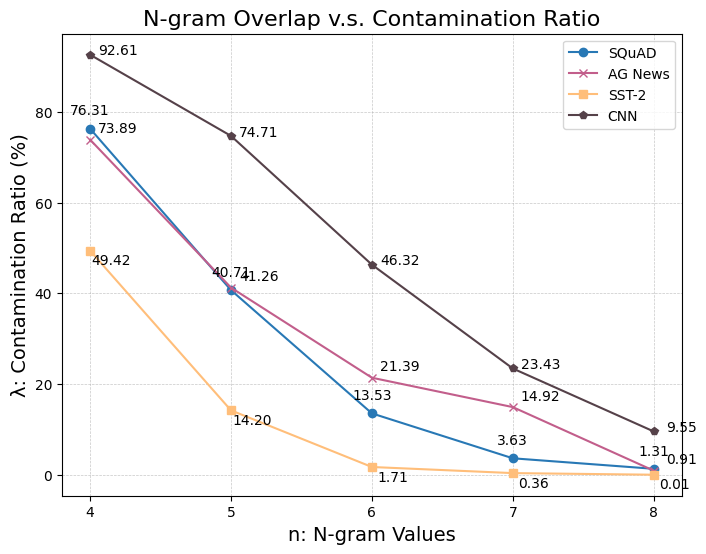

In [20]:
squad_n_values = [4, 5, 6, 7, 8]
squad_ratio_values = [76.30649, 40.7087, 13.53216, 3.63117, 1.31284]

ag_n_values = [4, 5,6,7,8]
ag_ratio = [73.889, 41.25787, 21.39384, 14.91571, 0.905293]

sst_n_values = [4,5,6,7,8]
sst_ratio = [49.4165, 14.1984, 1.7106, 0.3641, 0.00827]

cnn_n_values = [4,5,6,7,8]
cnn_ratio = [92.61, 74.71, 46.32, 23.43, 9.55]

# fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
plt.figure(figsize=(8,6))
for x, y in zip(squad_n_values, squad_ratio_values):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.plot(squad_n_values, squad_ratio_values, marker='o', linestyle='-', color='#2878B5', label='SQuAD')

for x, y in zip(ag_n_values, ag_ratio):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot(ag_n_values, ag_ratio, marker='x', linestyle='-', color='#C25E8B', label='AG News')

for x, y in zip(sst_n_values, sst_ratio):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(15,-10), ha='center')

plt.plot(sst_n_values, sst_ratio, marker='s', linestyle='-', color='#FFBE7A', label='SST-2')

for x, y in zip(cnn_n_values, cnn_ratio):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(20,0), ha='center')

plt.plot(cnn_n_values, cnn_ratio, marker='p', linestyle='-', color='#554149', label='CNN')

plt.title('N-gram Overlap v.s. Contamination Ratio', fontsize=16)
plt.xlabel('n: N-gram Values', fontsize=14)
plt.ylabel('\u03BB: Contamination Ratio (%)', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.savefig("./ngram.png", dpi=300)

In [2]:
import numpy as np
res =  [0.544878171910496, 0.5565932679030127, 0.5546927200106906, 0.5564596356293338, 0.5581820071567507, 0.561017980964825, 0.5578850465485753, 0.5411661643083046, 0.5102674130276619, 0.5574544536667211]
print(np.mean(res))

0.5498596861126371
